In [1]:
#!nvidia-smi

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Load data

In [4]:
# Load CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# Split (8000) of training data into temporary set
X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
print(f"X_temp.shape: {X_temp.shape}\n")

# Split temp data into equal validation (4000) and testing (4000) data
X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_temp_val.shape: {X_temp_val.shape}")
print(f"y_temp_val.shape: {y_temp_val.shape}")
print(f"X_temp_test.shape: {X_temp_test.shape}")
print(f"y_temp_test.shape: {y_temp_test.shape}\n")

# Split test data into validation (5000) and testing (5000)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
X_val = np.concatenate((X_val, X_temp_val), axis=0)
y_val = np.concatenate((y_val, y_temp_val), axis=0)
X_test = np.concatenate((X_test, X_temp_test), axis=0)
y_test = np.concatenate((y_test, y_temp_test), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)


labels[16119].shape: (1,)
imgs[16119].shape: (32, 32, 3)


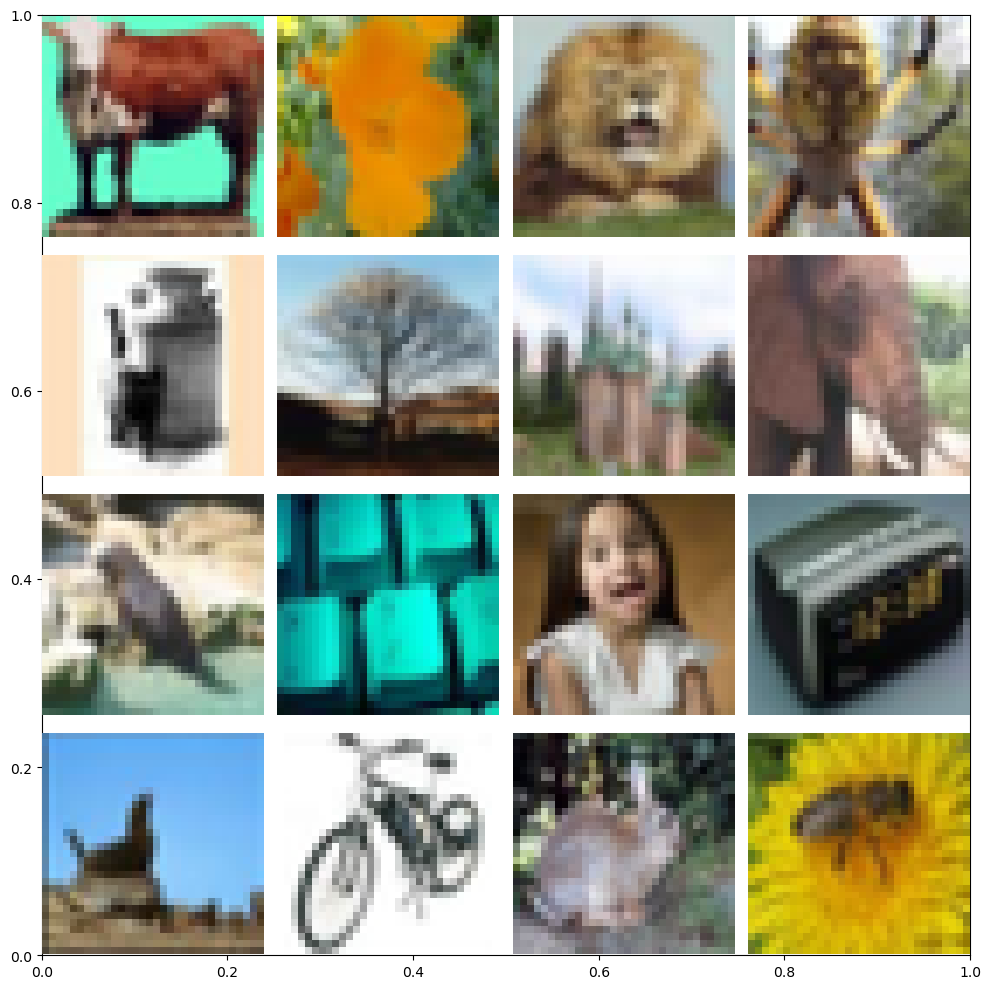

labels[3823].shape: (1,)
imgs[3823].shape: (32, 32, 3)


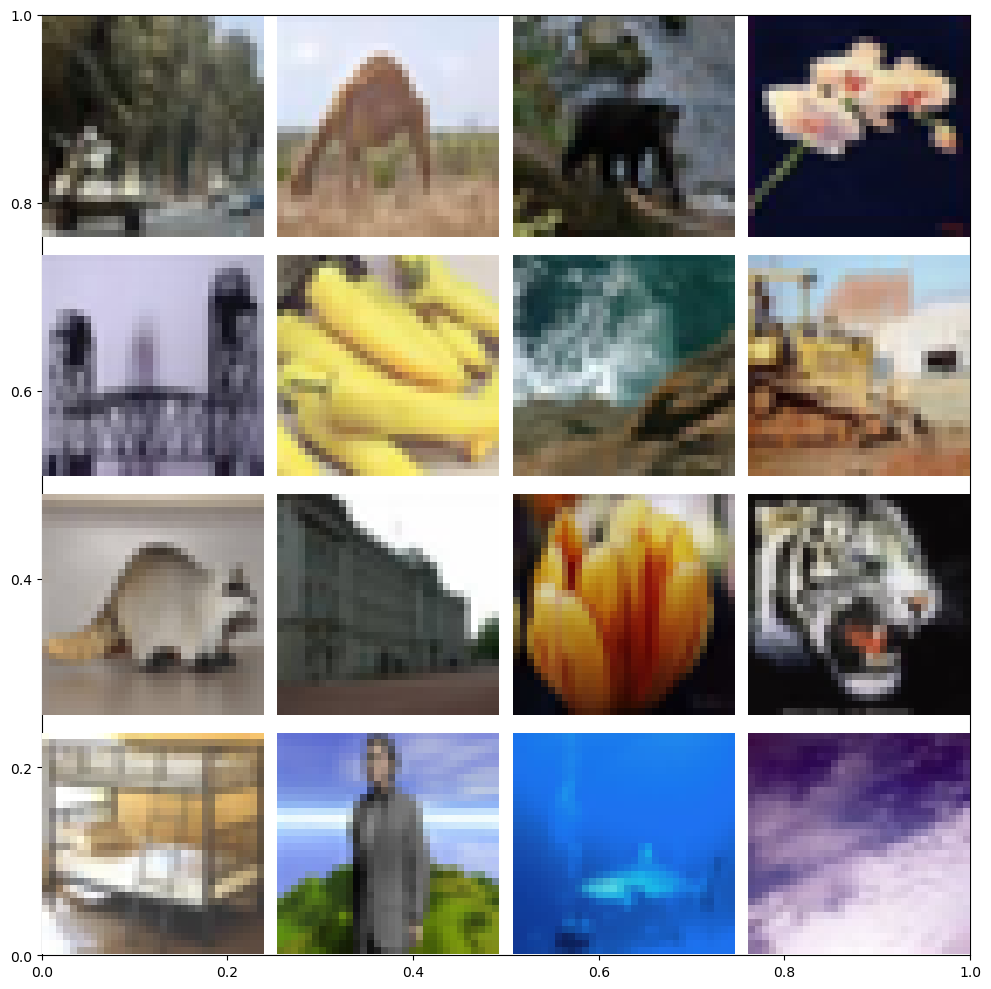

In [5]:
def display_imgs(imgs, labels):
    plt.subplots(figsize=(10,10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        k = np.random.randint(0, imgs.shape[0])
        if i == 0:
            print(f"labels[{k}].shape: {labels[k].shape}")
            print(f"imgs[{k}].shape: {imgs[k].shape}")
        plt.imshow(imgs[k])
        #plt.title(labels[k])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_imgs(X_train, y_train)

# Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
display_imgs(X_train, y_train)

C:\Users\andre\AppData\Local\Temp\ipykernel_4584\490141786.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


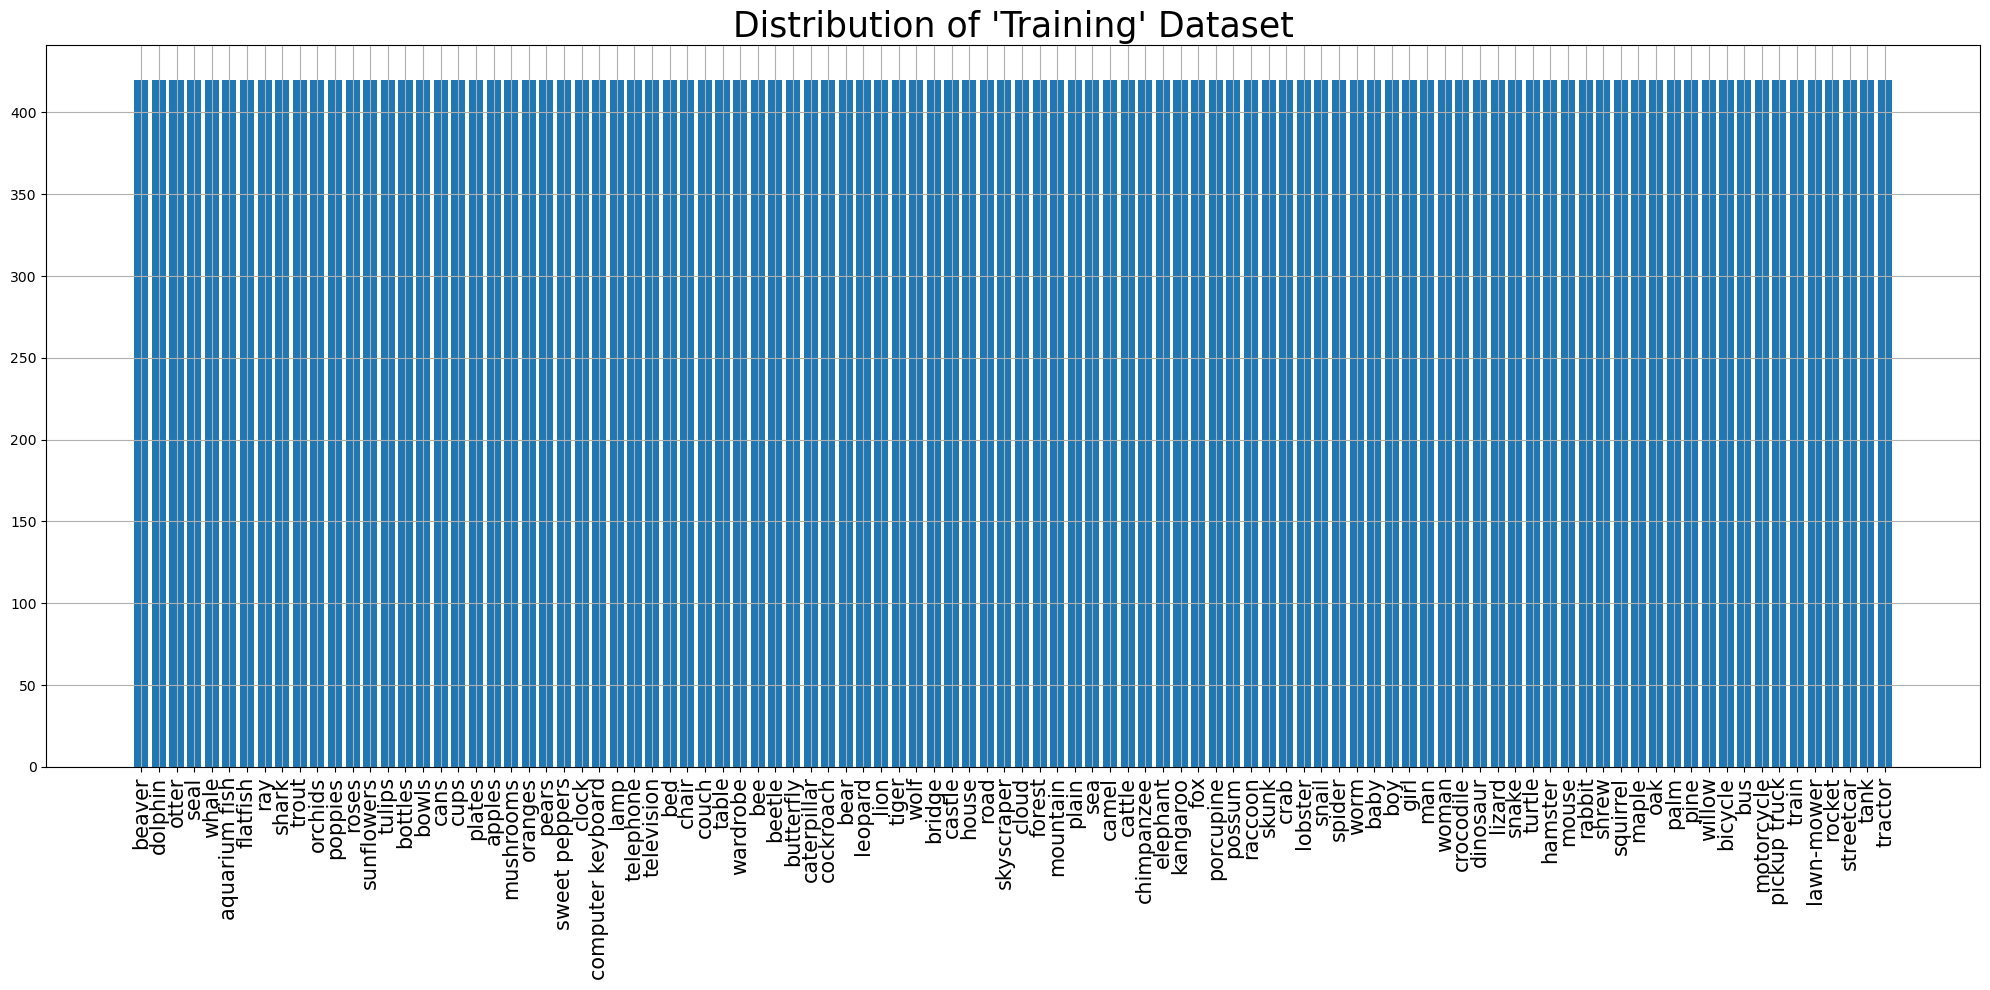

C:\Users\andre\AppData\Local\Temp\ipykernel_4584\490141786.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


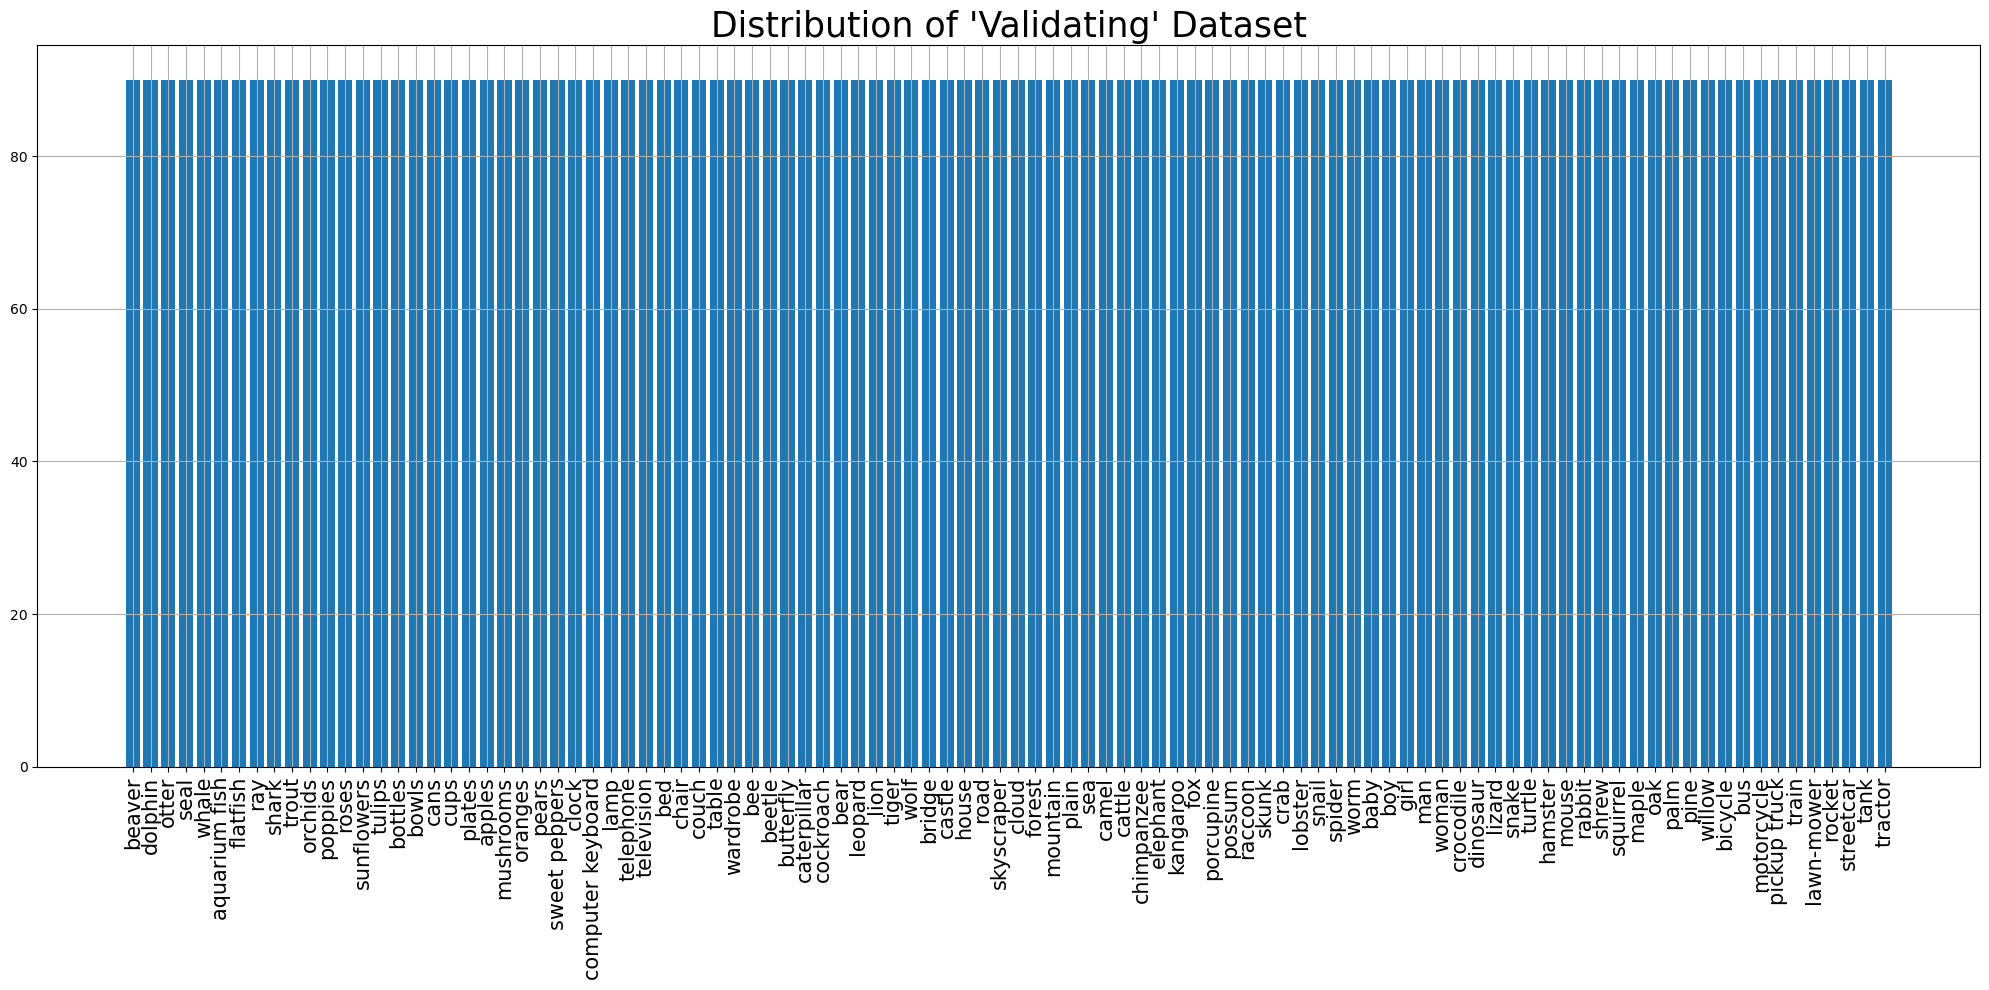

C:\Users\andre\AppData\Local\Temp\ipykernel_4584\490141786.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


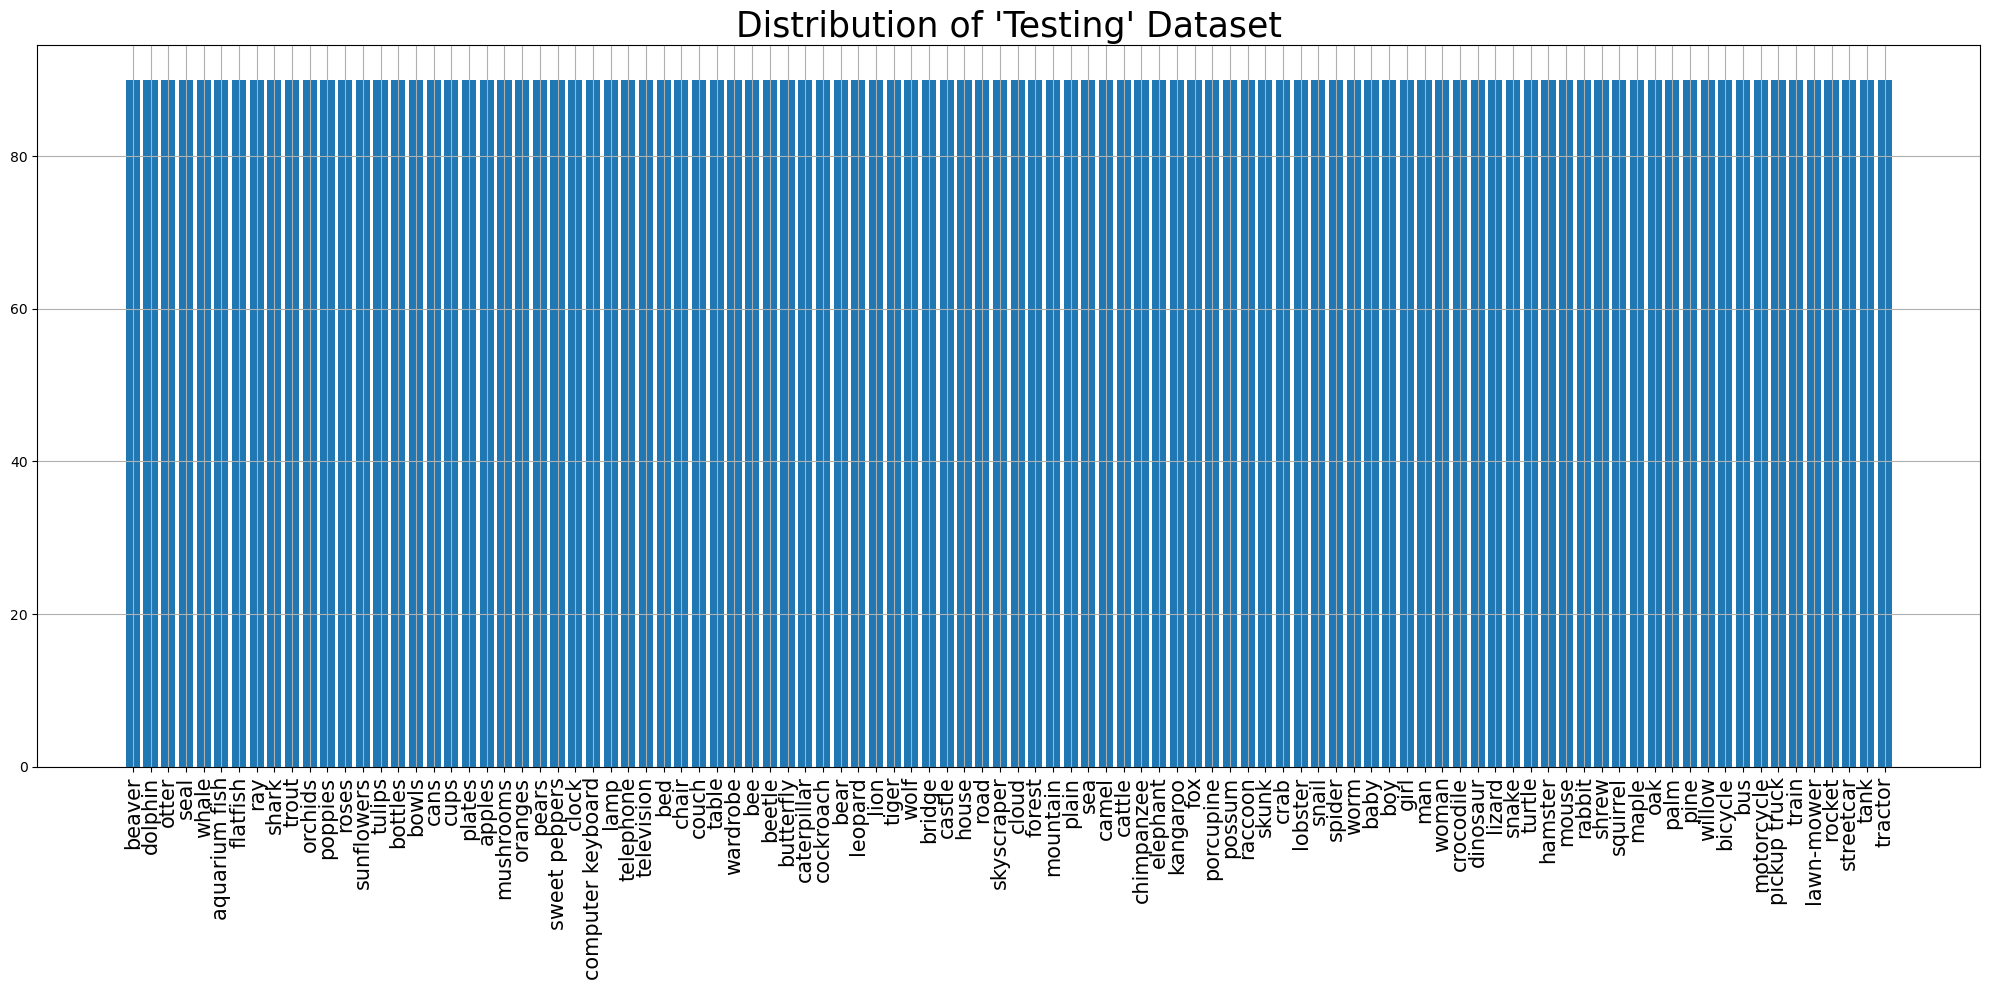

In [6]:
labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
               'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
               'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
               'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
               'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
               'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
               'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
               'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
               'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
               'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
               'tractor']

def class_distrib(y, labels_names, dataset_name):
    counts = pd.DataFrame(data=y).value_counts().sort_index()
    #print(f"counts:\n{counts}")
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(labels_names, counts)
    ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
    plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
    plt.grid()
    plt.tight_layout()
    plt.show()
class_distrib(y_train, labels_names, "Training")
class_distrib(y_val, labels_names, "Validating")
class_distrib(y_test, labels_names, "Testing")

In [ ]:
# Create TensorFlow datasets

batch_size = 64
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
               .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                  tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
               .batch(batch_size)
               .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

print(f"Training dataset:\n {train_dataset}")
for img, lbl in train_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nValidation dataset:\n {val_dataset}")
for img, lbl in val_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nTesting dataset:\n {test_dataset}")
for img, lbl in test_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl

# Define Model

### Use pre-trained model

In [ ]:
#### Set up model
# Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
resnet_50_base.trainable = False

# Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
model = models.Sequential([
    resnet_50_base,
    layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

for sample in test_dataset.take(1):
    print(type(sample))  # Should be <class 'tuple'>
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
    print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
    print(sample[1].shape)  # Should be (batch_size, 100)
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
sample = next(iter(test_dataset.as_numpy_iterator()))
print(len(sample))  # Should be 2
print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
print(sample[0].shape, sample[1].shape)  # Should match model input and output
print("\n")
#for x, y in test_dataset.take(1):
#    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
#for x_batch, y_batch in test_dataset.take(1):
#    test_loss, test_acc = model.evaluate(x_batch, y_batch)
#    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Compile the model
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'f1_score'])

model.summary()

#### Train Model & Track Training/Validation Error
early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                               patience=5, # Num. epochs with no improvements - help void overfitting
                               restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
#                              factor=0.1, # Reduce lr by a factor
#                              patience=3, # Num epochs w/ no improvement
#                              min_lr=1e-6, # Min lr
#                              verbose=1)
#tensorboard = TensorBoard(log_dir='./logs', # Logs directory
#                         histogram_freq=1, # Logs histograms for weights/activations
#                         write_graph=True, # Logs graph of model
#                         write_images=True) # Log images like weight histogram
#checkpoint = ModelCheckpoint('best_model.h5',
#                             monitor='val_loss', # or val_accuracy
#                             save_best_only=True, # Save only best model
#                             mode='min', # min for loss or max for accuracy
#                             verbose=1)
#cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, 
                    batch_size=batch_size, callbacks=[early_stopping], verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
results = model.evaluate(test_dataset)
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]
test_f1_scores = results[3]
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

#### Generate Confusion Matrix

# Get predictions
X_test_revised = tf.image.resize(X_test, (224, 224))
y_pred = model.predict(X_test_revised)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
#tensorboard --logdir==path_to_your_logs

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Finally, display the hist DataFrame.
hist

### Fine-tune model

In [ ]:
#### Adapt model
# Unfreeze last 10 layers
for layer in resnet_50_base.layers[-10:]:
    layer.trainable = True # Allow layers to be updated

# Compile again w/ lower learning rate (prevents destroying learned features)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Modify datasets
def augment_dataset(x, y):
    x = tf.image.resize(x, (224, 224))  # Resize images
    x = tf.image.random_flip_left_right(x)  # Random horizontal flip
    x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
    x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
    y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
    return x, y
train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))
# Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

#### Train Model & Track Training/Validation Error

# Train the model
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=15,
                              batch_size=batch_size, callbacks=[early_stopping], verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history_fine_tune.history['loss'])+1)
train_loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
train_acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
X_test_revised = tf.image.resize(X_test, (224, 224))
y_pred = model.predict(X_test_revised)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history_fine_tune.history)
hist['epoch'] = history_fine_tune.epoch

# Finally, display the hist DataFrame.
hist